In [1]:
! pip install joblib
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from influxdb import InfluxDBClient
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [3]:
class PredictionModel:
    def __init__(self):
        self.X_train, self.y_train = [], []
        self.X_test, self.y_test = [], []
        self.model = None

        # Configuration
        self.PE_GAS = 1.00
        self.PE_ELEC = 2.17
        self.COP_H = 0.98
        self.EER_C = 5.4
        self.group_time = '1h'  # Grouping interval for resampling

    def load_from_influx(self, client, measurement_observation, measurement_action, start, end):
        """
        Retrieves data from InfluxDB and prepares it for the ML model.
        """
        # Query the specific FMU fields
        influxql_query_observation = f'''
        SELECT MEAN("value") AS "val"
        FROM "{measurement_observation}"
        WHERE time >= '{start}'
            AND time < '{end}'
            AND "name" =~ /^(DistrictHeating|DistrictCooling|Electricity|Tair_z1|Tair_z2|Tair_z3|Tair_z4|T_ext|DNI)$/
        GROUP BY time({self.group_time}), "name"
        fill(previous)
        '''

        influxql_query_action = f'''
        SELECT MEAN("value") AS "val"
        FROM "{measurement_action}"
        WHERE time >= '{start}'
            AND time < '{end}'
            AND "name" =~ /^(Zona1_wall2_shade_FMU|Zona1_wall8_shade_FMU|Zona1_wall9_shade_FMU|Zona2_wall2_shade_FMU|Zona2_wall3_shade_FMU|Zona4_wall2_shade_FMU)$/
        GROUP BY time({self.group_time}), "name"
        fill(previous)
        '''

        # Query Data and Process into DataFrame
        result_observation = client.query(influxql_query_observation)
        result_action = client.query(influxql_query_action)
        #result = result_observation.merge(result_action)

        records = []

        
        # Iterate over the result set to build a DataFrame
        for result in (result_observation, result_action):
            for (m, tags), points in result.items():
                name_tag = tags.get('name')
                for p in points:
                    p['name'] = name_tag # add the 'name' tag to each point
                    records.append(p)

        df = pd.DataFrame(records)

        print(df.head())
        print(df.columns)
        print(df['name'].unique())

        if df.empty:
            print("No data returned.")
            return

        # Convert 'time' to datetime
        df['time'] = pd.to_datetime(df['time'])

        # Pivot the DataFrame to have separate columns for each 'name'
        df = df.pivot_table(
            index='time',
            columns='name',
            values='val'
        ).reset_index()
        
        # Unit Conversion: data is in Joules, convert to kWh (J / 3,600,000)
        energy_fields = ['Electricity', 'DistrictHeating', 'DistrictCooling']
        for field in energy_fields:
            if field in df.columns:
                df[field] = df[field] / 3600000 
        
        return df

    def split(self, dataset, train_ratio):
        """
        Prepares features and targets. Splits into training and testing sets.
        """
        # Feature Engineering
        # Mean Air Temperature across zones
        tair_cols = ['Tair_z1', 'Tair_z2', 'Tair_z3', 'Tair_z4']
        dataset['Tair_mean'] = dataset[tair_cols].mean(axis=1)

        # Delta T Indoor-Outdoor
        dataset['DeltaT'] = dataset['Tair_mean'] - dataset['T_ext']

        # Average Shade Position
        shade_cols = [
            'Zona1_wall2_shade_FMU',
            'Zona1_wall8_shade_FMU',
            'Zona1_wall9_shade_FMU',
            'Zona2_wall2_shade_FMU',
            'Zona2_wall3_shade_FMU',
            'Zona4_wall2_shade_FMU'
        ]
        dataset['mean_shade'] = dataset[shade_cols].mean(axis=1) / 7.0

        # Temporal Features
        # 24-hour cycle
        dataset['hour'] = dataset['time'].dt.hour
        dataset['hour_sin'] = np.sin(2 * np.pi * dataset['hour'] / 24)
        dataset['hour_cos'] = np.cos(2 * np.pi * dataset['hour'] / 24)

        # Yearly cycle
        dataset['dayofyear'] = dataset['time'].dt.dayofyear
        dataset['doy_sin'] = np.sin(2 * np.pi * dataset['dayofyear'] / 365)
        dataset['doy_cos'] = np.cos(2 * np.pi * dataset['dayofyear'] / 365)

        # Lag Features for targets
        dataset['Electricity_lag1'] = dataset['Electricity'].shift(1)
        dataset['DistrictHeating_lag1'] = dataset['DistrictHeating'].shift(1)
        dataset['DistrictCooling_lag1'] = dataset['DistrictCooling'].shift(1)

        # Features based on building sensors
        X_cols = [
            'T_ext',
            'DNI',
            'Tair_mean',
            'DeltaT',
            'mean_shade',
            'hour_sin',
            'hour_cos',
            'doy_sin',
            'doy_cos',
            'Electricity_lag1',
            'DistrictHeating_lag1',
            'DistrictCooling_lag1'
        ]
        X = dataset[X_cols]

        # Target: Individual components [Electricity, Heating, Cooling]
        y = dataset[['Electricity', 'DistrictHeating', 'DistrictCooling']]
    
        # Split into training and testing sets
        split_point = int(len(X) * train_ratio)
        self.X_train, self.y_train = X.iloc[:split_point], y.iloc[:split_point]
        self.X_test, self.y_test = X.iloc[split_point:], y.iloc[split_point:]

    def compute_total_primary_energy(self, df):
        """
        Computes Total Primary Energy from individual components.
        """
        df['Total_Primary_Energy'] = (
            (df['DistrictHeating'] / self.COP_H * self.PE_GAS) + 
            (df['DistrictCooling'] / self.EER_C * self.PE_ELEC) + 
            (df['Electricity'] * self.PE_ELEC)
        )
        return df

    def train(self):
        """Trains the XGBoost model."""
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror'
        )
        self.model = MultiOutputRegressor(model)
        self.model.fit(self.X_train, self.y_train)
        print("Model trained on InfluxDB data")

    def get_test_predictions(self):
        """
        Calculates the actual test values and corresponding predictions.
        
        Raises:
            ValueError: If the model is not trained or test data is missing.

        Returns:
            y_pred: np.array of predicted values for the test set.
        """
        if self.model is None:
            raise ValueError("Model is not trained. Please run the train method first.")
        if self.X_test.empty or self.y_test.empty:
            raise ValueError("Test data is not available. Please run the split method first.")
            
        # Make predictions on the unseen test set
        y_pred = self.model.predict(self.X_test)
        return y_pred
    
    def test_and_evaluate(self):
        """
        Evaluates the model.
        """
        try:
            predictions = self.get_test_predictions()
        except ValueError as e:
            print(f"Plotting Error: {e}")
            return
        
        print(f"\n--- Evaluation Results ---")

        targets = ['Electricity', 'DistrictHeating', 'DistrictCooling']
        df_pred = pd.DataFrame(predictions, columns=targets, index=self.y_test.index)
        df_actual = self.y_test.copy()

        df_pred = self.compute_total_primary_energy(df_pred)
        df_actual = self.compute_total_primary_energy(df_actual)

        all_targets = targets + ['Total_Primary_Energy']
        
        # Evaluate individual components
        for i, target_name in enumerate(all_targets):
            mse = mean_squared_error(df_actual[target_name], df_pred[target_name])
            r2 = r2_score(df_actual[target_name], df_pred[target_name])
            print(f"{target_name} -> MSE: {mse:.8e}, R²: {r2:.4f}")
        
    def save_model(self, filepath):
        """
        Saves the trained XGBoost model to a file using joblib for persistent storage.

        Args:
            filepath (str): The complete path and filename for saving the model.

        Returns:
            None: Prints a success or error message.
        """
        if self.model is None:
            print("ERROR: Model is not trained. Cannot save.")
            return

        try:
            # Save the model object
            joblib.dump(self.model, filepath)
            print(f"Model successfully saved to: {filepath}")
        except Exception as e:
            print(f"ERROR: Failed to save model: {e}")
    
    def load_model(self, filepath):
        """
        Loads a trained XGBoost model from a file using joblib.

        Args:
            filepath (str): The complete path and filename of the model file.

        Returns:
            None: Updates the internal self.model attribute. Prints an error message.
        """
        try:
            # Load the model object
            self.model = joblib.load(filepath)
        except FileNotFoundError:
            print(f"ERROR: Model file not found at: {filepath}")
        except Exception as e:
            print(f"ERROR: Failed to load model: {e}")

    # --- Plotting Methods ---
        
    def plot_feature_importance(self):
        """
        Plots Feature Importance with fixed scaling and explicit feature names.
        """
        if self.model is None:
            print("Model not trained.")
            return

        targets = ['Electricity', 'DistrictHeating', 'DistrictCooling']
        # Explicitly get feature names from your training data
        feature_names = self.X_train.columns.tolist()

        for i, target_name in enumerate(targets):
            # Create a fresh figure for each plot to avoid 'image size' issues
            plt.figure(figsize=(10, 8)) 
            
            # Access the underlying XGBoost booster
            ax = plt.gca()
            booster = self.model.estimators_[i].get_booster()
            
            # Manually set the feature names in the booster
            booster.feature_names = feature_names
            
            # Plot using 'gain' (usually more informative than 'weight')
            xgb.plot_importance(booster, importance_type='gain', ax=ax, 
                                show_values=False, title=f"Importance: {target_name}")
            
            plt.tight_layout()
            plt.show()

    def plot_scatter_error(self):
        """
        Plots Predicted vs Actual values for all targets and Total Primary Energy,
        colored by absolute error.
        """
        try:
            predictions = self.get_test_predictions()
        except ValueError as e:
            print(f"Plotting Error: {e}")
            return

        # Prepare DataFrames for easy calculation
        targets = ['Electricity', 'DistrictHeating', 'DistrictCooling']
        df_pred = pd.DataFrame(predictions, columns=targets, index=self.y_test.index)
        df_actual = self.y_test.copy()

        # Add Total Primary Energy to both
        df_pred = self.compute_total_primary_energy(df_pred)
        df_actual = self.compute_total_primary_energy(df_actual)

        # If dataset is huge, sample it to prevent the "Image size" error
        if len(df_actual) > 10000:
            sample_idx = df_actual.sample(10000).index
            df_actual = df_actual.loc[sample_idx]
            df_pred = df_pred.loc[sample_idx]
        
        all_targets = targets + ['Total_Primary_Energy']
        
        # Create Subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        for i, col in enumerate(all_targets):
            actual = df_actual[col]
            pred = df_pred[col]
            errors = np.abs(pred - actual)

            sc = axes[i].scatter(actual, pred, c=errors, cmap="coolwarm", s=20, alpha=0.7)
            fig.colorbar(sc, ax=axes[i], label="Abs Error")
            
            # Identity line
            min_val = min(actual.min(), pred.min())
            max_val = max(actual.max(), pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], color="black", linestyle='--', linewidth=1)
            
            axes[i].set_title(f"Actual vs Predicted: {col}")
            axes[i].set_xlabel("Actual (kWh or PE)")
            axes[i].set_ylabel("Predicted (kWh or PE)")
            axes[i].grid(True)
        
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_error_vs_actual(self):
        """
        Plots the prediction residual error (Predicted - Actual) against the actual PV generation.
        This helps identify if the model's error is correlated with the magnitude of the target variable.
        """
        try:
            predictions = self.get_test_predictions()
        except ValueError as e:
            print(f"Plotting Error: {e}")
            return

        targets = ['Electricity', 'DistrictHeating', 'DistrictCooling']
        df_pred = pd.DataFrame(predictions, columns=targets, index=self.y_test.index)
        df_actual = self.y_test.copy()

        df_pred = self.compute_total_primary_energy(df_pred)
        df_actual = self.compute_total_primary_energy(df_actual)

        # If dataset is huge, sample it to prevent the "Image size" error
        if len(df_actual) > 10000:
            sample_idx = df_actual.sample(10000).index
            df_actual = df_actual.loc[sample_idx]
            df_pred = df_pred.loc[sample_idx]

        all_targets = targets + ['Total_Primary_Energy']
    
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for i, col in enumerate(all_targets):
            actual = df_actual[col]
            residual = df_pred[col] - actual

            axes[i].scatter(actual, residual, s=15, alpha=0.6, color='tab:blue')
            axes[i].axhline(0, color="black", linewidth=1.5, linestyle='--')
            
            axes[i].set_title(f"Residuals: {col}")
            axes[i].set_xlabel("Actual Value")
            axes[i].set_ylabel("Error (Pred - Actual)")
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()
        plt.close()

In [4]:
# InfluxDB Connection Details
INFLUX_HOST = 'influxdb'       # The host where InfluxDB is running
INFLUX_PORT = 8086              # The port
INFLUX_USER = 'admin'           # Username
INFLUX_PASS = 'admin123'        # Password
INFLUX_DB   = 'controlled_building' # Name of the BMS database

# Configuration
MEASUREMENT_OBSERVATION = "simulation_observations" # The measurement containing these fields
MEASUREMENT_ACTION = "simulation_actions"
YEAR = 2025
# Full year
#START = f"{YEAR}-01-01T00:00:00Z"
#END = f"{YEAR + 1}-01-01T00:00:00Z"
# Summer
START = f"{YEAR}-06-01T00:00:00Z"
END = f"{YEAR}-09-01T00:00:00Z"

# Initialize the Client
client = InfluxDBClient(
    host=INFLUX_HOST,
    port=INFLUX_PORT,
    username=INFLUX_USER,
    password=INFLUX_PASS,
    database=INFLUX_DB
)

assert client.ping(), "❌ Cannot reach InfluxDB"
print("✅ Connected to InfluxDB 1.x")

✅ Connected to InfluxDB 1.x


In [5]:
# Train the model
model = PredictionModel()
df_influx = model.load_from_influx(client, MEASUREMENT_OBSERVATION, MEASUREMENT_ACTION, START, END)
model.split(df_influx, 0.8)
model.train()

# Save the trained model
model.save_model("xgb_multioutput_model.joblib")

                   time  val name
0  2025-06-01T00:00:00Z  0.0  DNI
1  2025-06-01T01:00:00Z  0.0  DNI
2  2025-06-01T02:00:00Z  0.0  DNI
3  2025-06-01T03:00:00Z  0.0  DNI
4  2025-06-01T04:00:00Z  0.0  DNI
Index(['time', 'val', 'name'], dtype='object')
['DNI' 'DistrictCooling' 'DistrictHeating' 'Electricity' 'T_ext' 'Tair_z1'
 'Tair_z2' 'Tair_z3' 'Tair_z4' 'Zona1_wall2_shade_FMU'
 'Zona1_wall8_shade_FMU' 'Zona1_wall9_shade_FMU' 'Zona2_wall2_shade_FMU'
 'Zona2_wall3_shade_FMU' 'Zona4_wall2_shade_FMU']
Model trained on InfluxDB data
Model successfully saved to: xgb_multioutput_model.joblib


In [6]:
# Load the trained model
# model.load_model("xgb_multioutput_model.joblib")


--- Evaluation Results ---
Electricity -> MSE: 5.69681797e-06, R²: 0.8744
DistrictHeating -> MSE: 2.48375865e-06, R²: 0.9603
DistrictCooling -> MSE: 4.08432935e-06, R²: 0.9118
Total_Primary_Energy -> MSE: 4.33848921e-05, R²: 0.8495


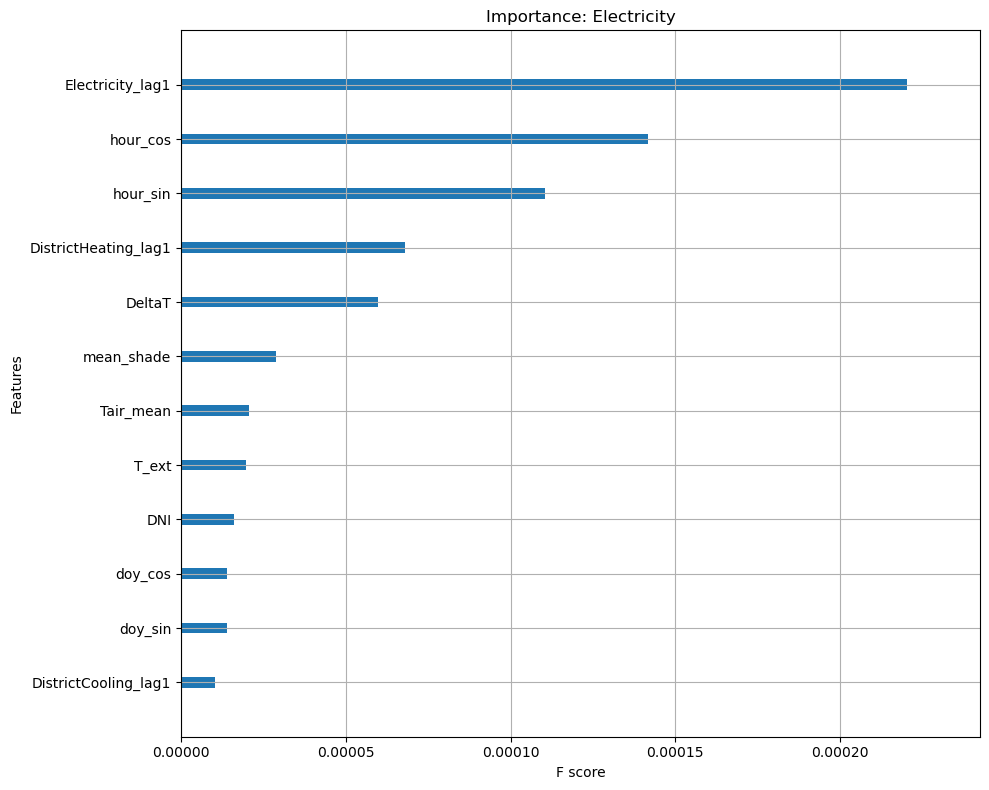

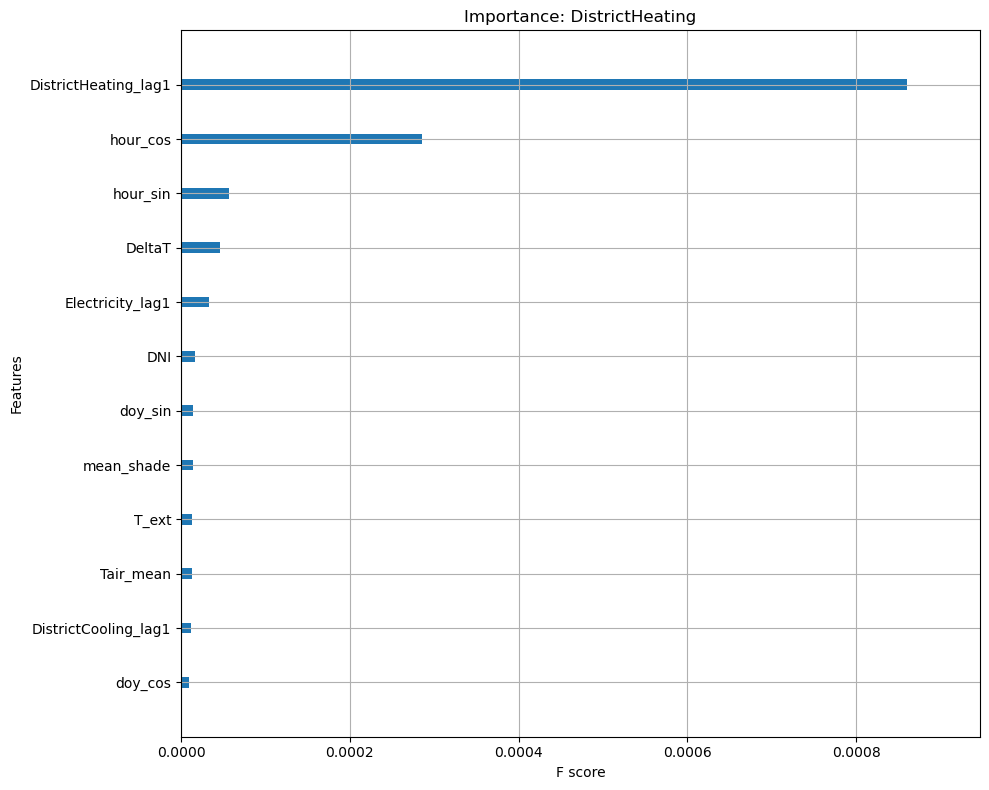

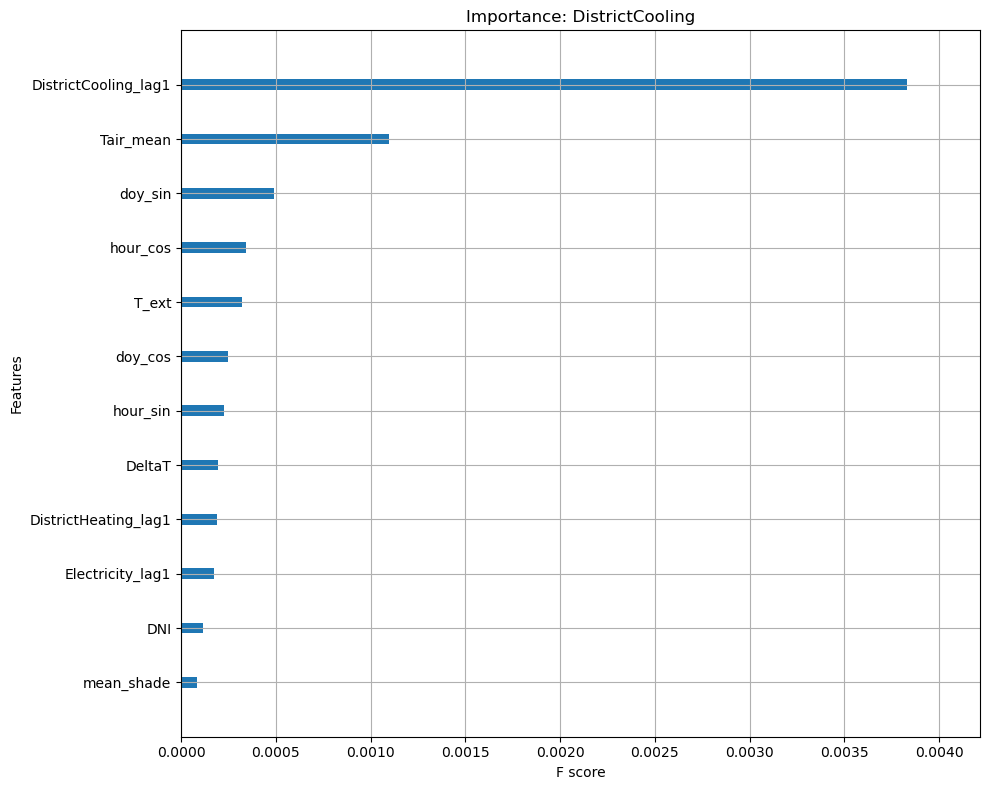

<Figure size 640x480 with 0 Axes>

Feature Importance shown


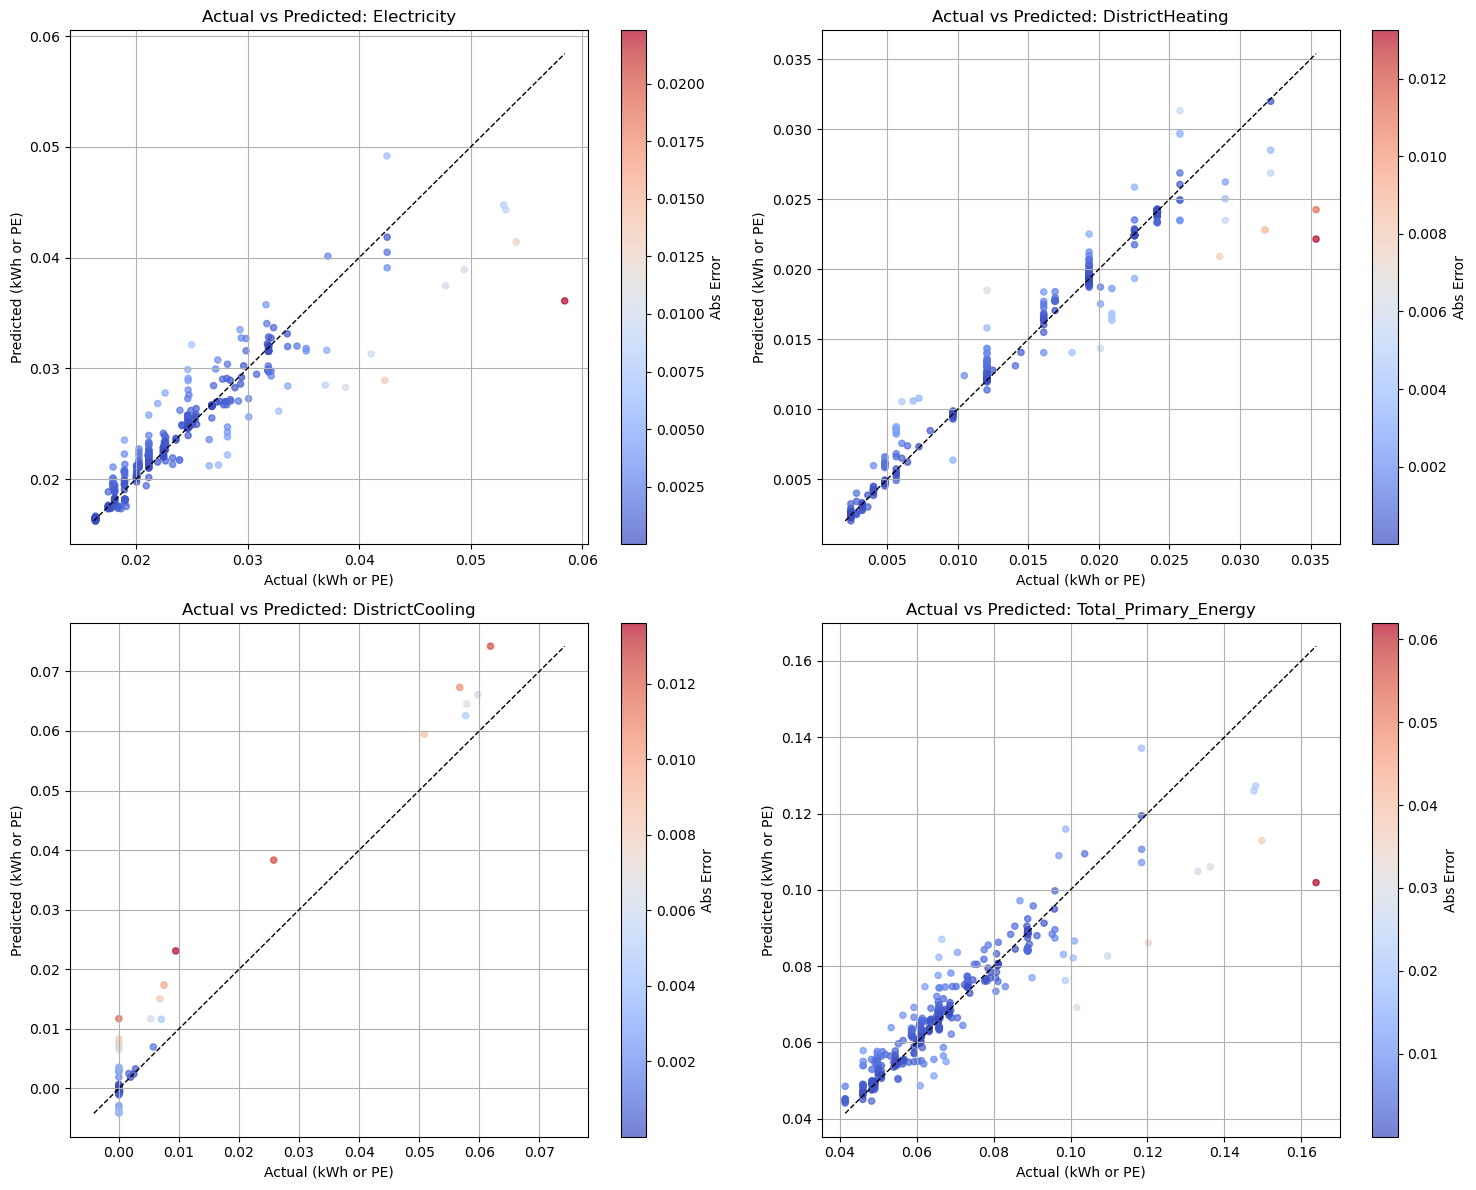

<Figure size 640x480 with 0 Axes>

scatter_error shown


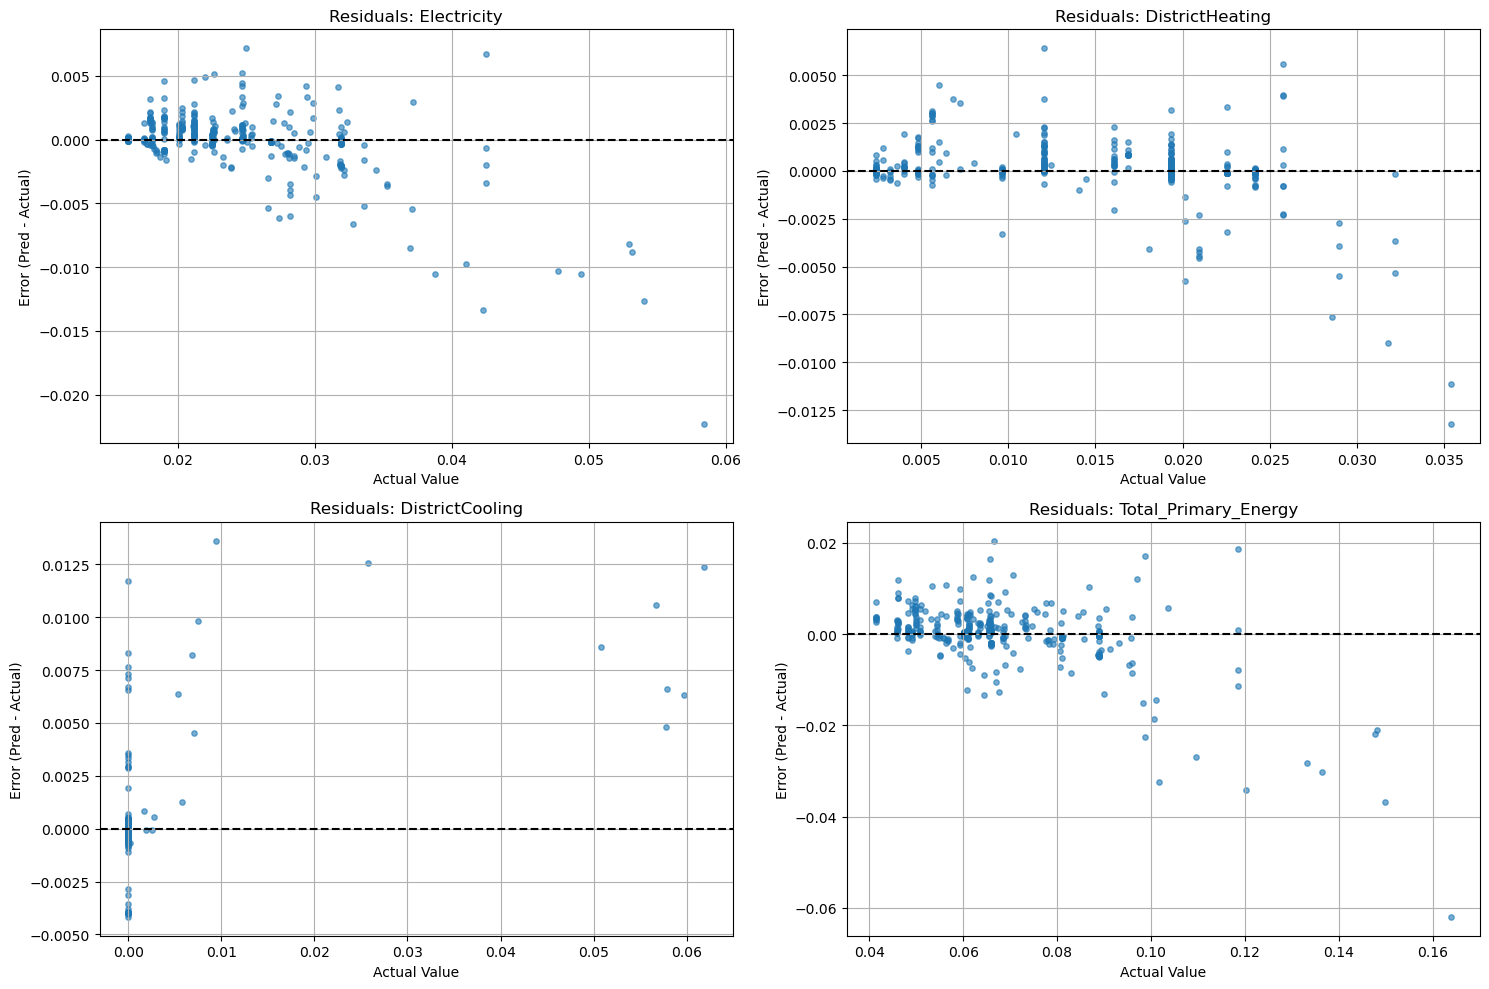

<Figure size 640x480 with 0 Axes>

error_vs_actual shown


In [7]:
# Evaluate the model
model.test_and_evaluate()
model.plot_feature_importance()
plt.tight_layout(); plt.show(); plt.close("all") 
print("Feature Importance shown")
model.plot_scatter_error()
plt.tight_layout(); plt.show(); plt.close("all") 
print("scatter_error shown")
model.plot_error_vs_actual()
plt.tight_layout(); plt.show(); plt.close("all") 
print("error_vs_actual shown")